# Chartmetric Exploratory Data Analysis

### Spotify Metric Index

Followers: Followers are listeners who hit follow or ❤ on a given artist profile.

Monthly Listeners: Monthly listeners are unique listeners who play the given artist's music within a rolling window of 28 days.

Popularity: A value will be between 0 and 100, with 100 being the most popular. The metric is calculated based on the number of listeners.

[Further Metric Explanation]( https://nnnehasingh15.medium.com/spotify-monthly-listeners-and-spotify-streams-explained-ba3752e9b872)

### Objective
Create new metric (artist score) off of popularity, followers, listeners, then deploy adhoc dashboard (UI). 
- range??
- meaning??
- purpose??

### Data Sets

The original data file contains 30 columns, the can be divided into five categories:
- Artist ID 
- followers stats
- listeners stats
- popularity stats
- followers to listeners ratio stats

Each stats group has the following columns:
- Subject: the name of the group, same value in every row
- weekly_diff
- weekly_diff_percent 
- monthly_diff 
- monthly_diff_percent  
- value: actual number of followers/listeners; a score between 1-100 for popularity  
- timestp: a date between January 1st 2020 and June 1st 2020 (this should not exist for each group)

## Implementation

#### Import necessary libraries and load data.

In [7]:
import pandas as pd
import numpy as np 

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
from scipy import stats  
import itertools


def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    pd.option_context('mode.use_inf_as_na', True)

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.reset_index(inplace=True)
    return df


set_view_options(max_colwidth=15)
df = load_data()
df.describe().round()

,index,weekly_diff,weekly_diff_percent,monthly_diff,monthly_diff_percent,value,weekly_diff.1,weekly_diff_percent.1,monthly_diff.1,monthly_diff_percent.1,value.1,weekly_diff.2,weekly_diff_percent.2,monthly_diff.2,monthly_diff_percent.2,value.2,weekly_diff.3,weekly_diff_percent.3,monthly_diff.3,monthly_diff_percent.3,value.3
count,19896.0,19598.0,19598.0,19598.0,19598.0,19896.0,19598.0,19214.0,19598.0,19216.0,19896.0,19328.0,19328.0,19372.0,19372.0,19812.0,19523.0,19328.0,19523.0,19372.0,19812.0
mean,9948.0,2199.0,0.0,8610.0,1.0,553320.0,0.0,0.0,0.0,1.0,51.0,-15129.0,-1.0,13083.0,-0.0,1655244.0,-0.0,1.0,0.0,4.0,533.0
std,5744.0,4990.0,0.0,20416.0,1.0,1193667.0,0.0,1.0,1.0,5.0,20.0,152900.0,4.0,325895.0,46.0,2798637.0,0.0,3.0,1.0,20.0,7763.0
min,0.0,-9.0,-0.0,-9.0,-6.0,1.0,-2.0,-8.0,-3.0,-100.0,0.0,-1117492.0,-25.0,-2026390.0,-68.0,1.0,-10.0,-21.0,-11.0,-90.0,0.0
25%,4974.0,34.0,0.0,150.0,1.0,16102.0,0.0,0.0,0.0,0.0,40.0,-19303.0,-2.0,-32950.0,-4.0,80629.0,0.0,0.0,0.0,-0.0,14.0
50%,9948.0,281.0,0.0,1113.0,1.0,101658.0,0.0,0.0,0.0,0.0,56.0,-1149.0,-1.0,-3388.0,-2.0,588473.0,0.0,1.0,0.0,3.0,29.0
75%,14921.0,1710.0,0.0,6491.0,2.0,561769.0,0.0,0.0,1.0,2.0,66.0,89.0,0.0,2893.0,2.0,2039442.0,0.0,2.0,0.0,6.0,47.0
max,19895.0,29900.0,3.0,149837.0,16.0,7861215.0,1.0,8.0,12.0,171.0,95.0,1203116.0,38.0,2611250.0,2756.0,37573946.0,4.0,32.0,15.0,218.0,299133.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   19896 non-null  int64  
 1   Chartmetric_ID          19896 non-null  object 
 2   Subject                 19896 non-null  object 
 3   weekly_diff             19598 non-null  float64
 4   weekly_diff_percent     19598 non-null  float64
 5   monthly_diff            19598 non-null  float64
 6   monthly_diff_percent    19598 non-null  float64
 7   value                   19896 non-null  float64
 8   timestp                 19896 non-null  object 
 9   Subject.1               19896 non-null  object 
 10  weekly_diff.1           19598 non-null  float64
 11  weekly_diff_percent.1   19214 non-null  float64
 12  monthly_diff.1          19598 non-null  float64
 13  monthly_diff_percent.1  19216 non-null  float64
 14  value.1                 19896 non-null

### Examining the Raw Data

In [9]:
df.head()

,index,Chartmetric_ID,Subject,weekly_diff,weekly_diff_percent,monthly_diff,monthly_diff_percent,value,timestp,Subject.1,weekly_diff.1,weekly_diff_percent.1,monthly_diff.1,monthly_diff_percent.1,value.1,timestp.1,Subject.2,weekly_diff.2,weekly_diff_percent.2,monthly_diff.2,monthly_diff_percent.2,value.2,timestp.2,Subject.3,weekly_diff.3,weekly_diff_percent.3,monthly_diff.3,monthly_diff_percent.3,value.3,timestp.3
0,0,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,180028.0,2020-01-02T...,popularity,0.0,0.0,0.0,0.0,61.0,2020-01-02T...,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1462956.0,2020-01-02T...,followers_t...,0.001702,1.325225,0.005711,4.590024,12.31,2020-01-02T...
1,1,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,180274.0,2020-01-04T...,popularity,0.0,0.0,0.0,0.0,62.0,2020-01-04T...,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1477611.0,2020-01-04T...,followers_t...,0.001702,1.325225,0.005711,4.590024,12.20,2020-01-04T...
2,2,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,180820.0,2020-01-08T...,popularity,0.0,0.0,0.0,0.0,62.0,2020-01-08T...,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1496908.0,2020-01-08T...,followers_t...,0.001702,1.325225,0.005711,4.590024,12.08,2020-01-08T...
3,3,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,181165.0,2020-01-10T...,popularity,0.0,0.0,0.0,0.0,62.0,2020-01-10T...,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1510227.0,2020-01-10T...,followers_t...,0.001702,1.325225,0.005711,4.590024,12.00,2020-01-10T...
4,4,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,181593.0,2020-01-14T...,popularity,0.0,0.0,0.0,0.0,62.0,2020-01-14T...,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1533155.0,2020-01-14T...,followers_t...,0.001702,1.325225,0.005711,4.590024,11.84,2020-01-14T...


From the above we can see that columns `Subject`, `Subject.1`, `Subject.2` and `Subject.3` contain the names of the four main feature categories: `followers`, `popularity`, `listeners` and `followers_to_listeners_ratio` respectively. Also, columns 3 to 8 concern `followers` data, columns 10 to 15 concern `popularity`, columns 17 to 22 concern `listeners` and columns 24 to 29 concern `followers_to_listeners_ratio`. 

Each group of features contain a timestamp field, some of which have conflicting values (null vs. not null). To clean that up, first we break up the original dataframe into four dataframes based on the above feature groups, then merge them back together and examine the data again.

### Eliminating Redundant Columns

In [10]:

def rename_columns(df):
      
    # create four dataframes with values, monthly and weekly features
    # and make columns names consistent
    df_fol = df.iloc[:, 3:8]
    df_pop = df.iloc[:, 10:15]   
    df_pop.columns = df_fol.columns
    df_lis = df.iloc[:, 17:22]    
    df_lis.columns = df_fol.columns
    df_flr = df.iloc[:, 24:29]    
    df_flr.columns = df_fol.columns
    
    # add in artist and timestamp
    df_fol = df_fol.add_prefix('fol_')
    df_fol['artist']  = df['Chartmetric_ID']
    df_fol['timestp'] = df['timestp']
    
    df_pop = df_pop.add_prefix('pop_')
    df_pop['artist']  = df['Chartmetric_ID']
    df_pop['timestp'] = df['timestp.1']
        
    df_lis = df_lis.add_prefix('lis_')
    df_lis['artist']  = df['Chartmetric_ID']
    df_lis['timestp'] = df['timestp.2']
        
    df_flr = df_flr.add_prefix('flr_')
    df_flr['artist']  = df['Chartmetric_ID']
    df_flr['timestp'] = df['timestp.3']
       
    df_fol = pd.merge(df_fol, df_pop, on=['artist', 'timestp'], how='left')
    df_fol = pd.merge(df_fol, df_lis, on=['artist', 'timestp'], how='left')
    df_fol = pd.merge(df_fol, df_flr, on=['artist', 'timestp'], how='left')
    
    return df_fol


df = rename_columns(df)    
df.describe()

,fol_weekly_diff,fol_weekly_diff_percent,fol_monthly_diff,fol_monthly_diff_percent,fol_value,pop_weekly_diff,pop_weekly_diff_percent,pop_monthly_diff,pop_monthly_diff_percent,pop_value,lis_weekly_diff,lis_weekly_diff_percent,lis_monthly_diff,lis_monthly_diff_percent,lis_value,flr_weekly_diff,flr_weekly_diff_percent,flr_monthly_diff,flr_monthly_diff_percent,flr_value
count,19598.000000,19598.000000,19598.000000,19598.000000,1.989600e+04,19598.000000,19214.000000,19598.000000,19216.000000,19896.000000,1.932800e+04,19328.000000,1.937200e+04,19372.000000,1.981200e+04,19523.000000,19328.000000,19523.000000,19372.000000,19812.000000
mean,2199.197265,0.324893,8609.634197,1.298044,5.533205e+05,0.163945,0.281955,0.344576,0.607582,51.155860,-1.512858e+04,-0.575322,1.308347e+04,-0.366497,1.655244e+06,-0.005054,1.091670,0.020046,4.369543,532.701848
std,4990.349254,0.266094,20416.477762,0.998367,1.193667e+06,0.372297,0.709221,0.747368,5.122036,20.305233,1.529002e+05,3.839480,3.258947e+05,45.882810,2.798637e+06,0.492734,3.489992,0.866763,19.743914,7763.420159
min,-9.000000,-0.042200,-9.000000,-5.555600,1.000000e+00,-2.000000,-8.333300,-3.000000,-100.000000,0.000000,-1.117492e+06,-25.000000,-2.026390e+06,-68.361000,1.000000e+00,-9.529624,-20.786092,-11.007003,-90.206569,0.210000
25%,34.000000,0.174500,150.000000,0.770500,1.610225e+04,0.000000,0.000000,0.000000,0.000000,40.000000,-1.930300e+04,-1.597500,-3.295000e+04,-4.405400,8.062900e+04,0.000000,0.022563,0.000000,-0.087651,13.650000
50%,281.000000,0.275100,1113.000000,1.124100,1.016580e+05,0.000000,0.000000,0.000000,0.000000,56.000000,-1.149000e+03,-0.724300,-3.388000e+03,-1.748000,5.884730e+05,0.002391,1.008176,0.006404,3.208656,28.540000
75%,1710.000000,0.422850,6491.000000,1.693600,5.617690e+05,0.000000,0.000000,1.000000,1.562500,66.000000,8.900000e+01,0.336500,2.893000e+03,1.522600,2.039442e+06,0.007545,2.100559,0.019850,5.938537,47.260000
max,29900.000000,2.525300,149837.000000,15.789500,7.861215e+06,1.000000,8.333300,12.000000,171.428600,95.000000,1.203116e+06,38.461500,2.611250e+06,2756.009100,3.757395e+07,4.258333,31.818182,15.376667,218.338571,299133.330000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19896 entries, 0 to 19895
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fol_weekly_diff           19598 non-null  float64
 1   fol_weekly_diff_percent   19598 non-null  float64
 2   fol_monthly_diff          19598 non-null  float64
 3   fol_monthly_diff_percent  19598 non-null  float64
 4   fol_value                 19896 non-null  float64
 5   artist                    19896 non-null  object 
 6   timestp                   19896 non-null  object 
 7   pop_weekly_diff           19598 non-null  float64
 8   pop_weekly_diff_percent   19214 non-null  float64
 9   pop_monthly_diff          19598 non-null  float64
 10  pop_monthly_diff_percent  19216 non-null  float64
 11  pop_value                 19896 non-null  float64
 12  lis_weekly_diff           19328 non-null  float64
 13  lis_weekly_diff_percent   19328 non-null  float64
 14  lis_mo

### Examining the Time Series Data 

Now let's look at the numerical columns and see how much they change over time:

In [12]:
cols = ['fol_weekly_diff', 'fol_weekly_diff_percent', 'fol_monthly_diff', 'fol_monthly_diff_percent', 'fol_value',
        'pop_weekly_diff', 'pop_weekly_diff_percent', 'pop_monthly_diff', 'pop_monthly_diff_percent', 'pop_value',
        'lis_weekly_diff', 'lis_weekly_diff_percent', 'lis_monthly_diff', 'lis_monthly_diff_percent', 'lis_value',
        'flr_weekly_diff', 'flr_weekly_diff_percent', 'flr_monthly_diff', 'flr_monthly_diff_percent', 'flr_value']

In [13]:
df1 = df.groupby(by='artist')[cols].min()
df2 = df.groupby(by='artist')[cols].max()
df_diff = df2 - df1
df_diff.describe().round()

,fol_weekly_diff,fol_weekly_diff_percent,fol_monthly_diff,fol_monthly_diff_percent,fol_value,pop_weekly_diff,pop_weekly_diff_percent,pop_monthly_diff,pop_monthly_diff_percent,pop_value,lis_weekly_diff,lis_weekly_diff_percent,lis_monthly_diff,lis_monthly_diff_percent,lis_value,flr_weekly_diff,flr_weekly_diff_percent,flr_monthly_diff,flr_monthly_diff_percent,flr_value
count,238.0,238.0,238.0,238.0,257.0,238.0,215.0,238.0,216.0,257.0,230.0,230.0,231.0,231.0,249.0,234.0,230.0,234.0,231.0,249.0
mean,0.0,0.0,0.0,0.0,25687.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,326978.0,0.0,0.0,0.0,0.0,1551.0
std,0.0,0.0,0.0,0.0,83753.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1966280.0,0.0,0.0,0.0,0.0,17836.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,2.0
50%,0.0,0.0,0.0,0.0,663.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,19092.0,0.0,0.0,0.0,0.0,6.0
75%,0.0,0.0,0.0,0.0,11738.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,215862.0,0.0,0.0,0.0,0.0,16.0
max,0.0,0.0,0.0,0.0,778789.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,30182576.0,0.0,0.0,0.0,0.0,255986.0


From this table we can conclude the following:
- out of all the above features, we only have non-null values for every row in the `fol_value` and `pop_value` columns
- zero difference between `min` and `max` values indicates that this feature does not change in time, i.e. we can only use the `fol_value`, `pop_value`, `lis_value` and `flr_value` columns in time series predictions.

### Visualizing Daily and Monthly Trends

Next, let's visualize the changes in the value columns over time for various artists. in order to do that, first let's convert the `timestp` column into numerical. All our data falls between January 1st and June 1st, so the simplest way is to introduce a column for # of days past since January 1st. 


In [17]:
df_diff[df_diff['pop_value'] >10]['pop_value']

artist
Govinda            16.0
Ingrid DuMosch     13.0
Michael Bublé      18.0
Natália Kelly      13.0
The Art Company    12.0
Name: pop_value, dtype: float64

In [18]:
base_date = pd.Timestamp('2020-01-01T00:00:00.000Z')
df['num_days'] = df.apply(lambda x: (pd.Timestamp(x.timestp) - base_date).days, axis=1)

df[['timestp', 'num_days']].head()

,timestp,num_days
0,2020-01-02T...,1
1,2020-01-04T...,3
2,2020-01-08T...,7
3,2020-01-10T...,9
4,2020-01-14T...,13


In [19]:
df[df['lis_value'] > 2.0e7]['artist'].unique()

array(['Michael Bublé'], dtype=object)

#### Number of Followers

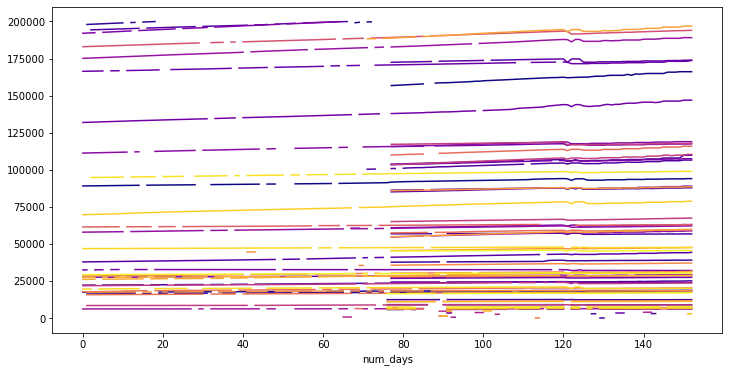

In [23]:
def display_daily_trend(data, colname, upper_limit=1.0e9, lower_limit=0):
    df1 = data[['artist', 'num_days', colname]][(data[colname] < upper_limit) & (data[colname] > lower_limit)]
    df1 = df1.pivot(index='num_days', columns='artist', values=colname)
    df1.plot.line(figsize=(12,6), colormap='plasma', legend=False);
    
def display_weekly_trend(data, colname, upper_limit=1.0e9, lower_limit=0):    
    df1 = data[['artist', 'num_weeks', colname]][(data[colname] < upper_limit) & (data[colname] > lower_limit)]
    df1 = df1.pivot(index='num_weeks', columns='artist', values=colname)
    df1.plot.line(figsize=(12,6), colormap='plasma', legend=False);
    
display_daily_trend(df, 'fol_value', upper_limit=2.0e5);    

The # of followers is constant or steadily increasing for most artists, except for a glitch around April 1st, which we will disregard for now. There is also clearly some missing datapoints, we can resolve that by working with weekly averages instead of daily values, which is reasonable, since most of these curves are very smooth. 

___Note:___ I decided against using weekly sums, because we have different number of datapoints for different weeks, so sums would result in inconsistent data. 

#### Number of Listeners

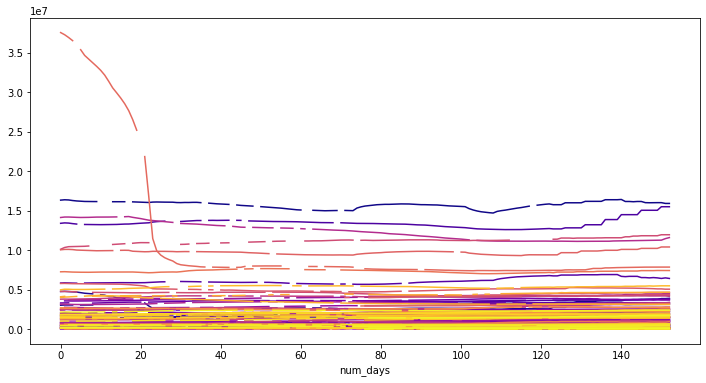

In [12]:
display_daily_trend(df, 'lis_value');    

The same can be said for the # of listeners (except for that one anomalous artist (Christmas song??)), so working with weekly averages instead of daily values is also reasonable. 

#### Popularity

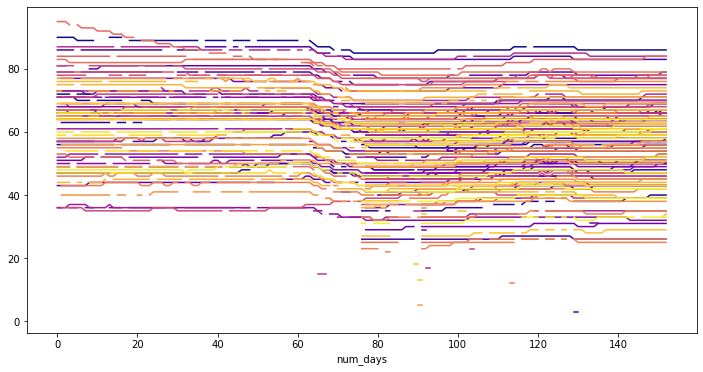

In [13]:
display_daily_trend(df, 'pop_value');    

According to these curves, most artists experienced a drop in popularity at the beginning of March, but then climbed back up in late March or early April.

For the weekly aggregation, first we generate a column `num_weeks` similar to `num_days`.

In [24]:
df['num_weeks'] = df.apply(lambda x: pd.Timestamp(x.timestp).week, axis=1)

df[['timestp', 'num_days', 'num_weeks']].head()

,timestp,num_days,num_weeks
0,2020-01-02T...,1,1
1,2020-01-04T...,3,1
2,2020-01-08T...,7,2
3,2020-01-10T...,9,2
4,2020-01-14T...,13,3


Then we aggregate the data in the value columns by `artist` and `num_weeks`, and create a `ts_data` (time series data) dataframe that only contains this new data.

In [15]:
cols = ['artist', 'num_weeks']
ts_data = df.groupby(by=cols, as_index=False)['fol_value'].mean()
ts_pop  = df.groupby(by=cols, as_index=False)['pop_value'].mean()
ts_lis  = df.groupby(by=cols, as_index=False)['lis_value'].mean()

ts_data = pd.merge(ts_data, ts_pop, on=cols, how='left')
ts_data = pd.merge(ts_data, ts_lis, on=cols, how='left')
ts_data.describe().round(2)

,num_weeks,fol_value,pop_value,lis_value
count,4339.00,4339.00,4339.00,4301.00
mean,12.07,419238.32,43.98,1299266.61
std,6.58,1051056.47,23.56,2535728.20
min,1.00,1.00,0.00,1.00
25%,6.00,2306.00,26.00,11467.00
50%,12.00,32664.71,48.00,201782.14
75%,18.00,326659.93,64.00,1595790.86
max,23.00,7861215.00,94.75,37091085.00


Now we can display the trends of number of followers, listeners and popularity code based on the weekly data. Notice that this time our graphs are much smoother.

#### Number of Followers

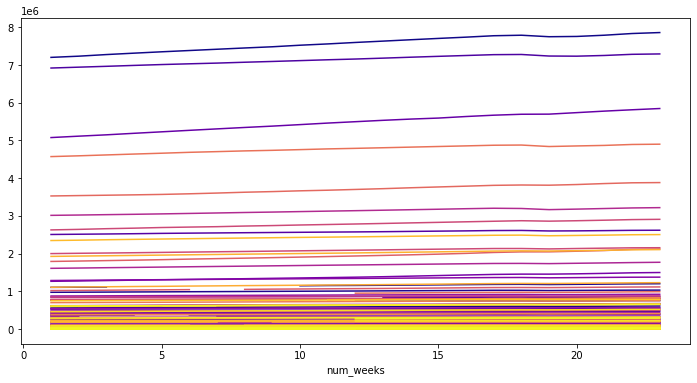

In [16]:
display_weekly_trend(ts_data, 'fol_value');    

#### Number of Listeners

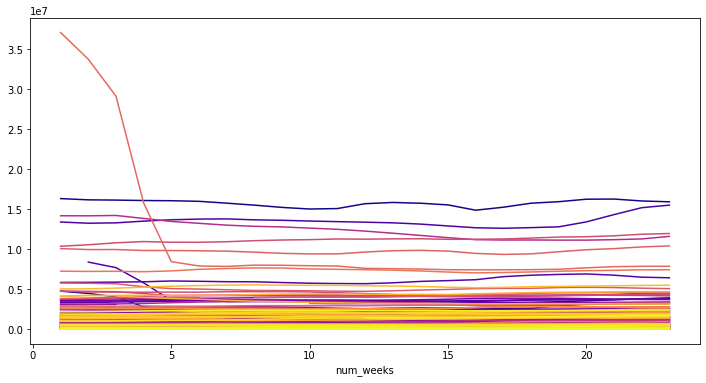

In [26]:
display_weekly_trend(ts_data, 'lis_value');    

Also notice, that the density of curves increases as we go to the lower values for both followers and listeners, we might get a more even distribution using a logarithmic transformation on these values. 

#### Popularity

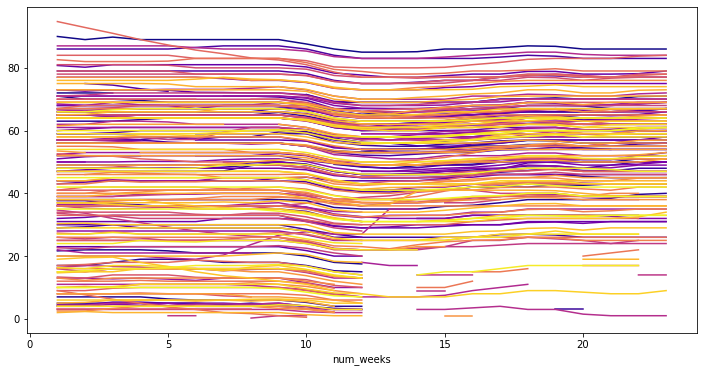

In [18]:
#idx = ts_data.artist.isin(['Govinda', 'Ingrid DuMosch', 'Michael Bublé', 'Natália Kelly', 'The Art Company'])
display_weekly_trend(ts_data, 'pop_value');    

Let's see the same visualization for followers and listeners, but this time applying log transform.

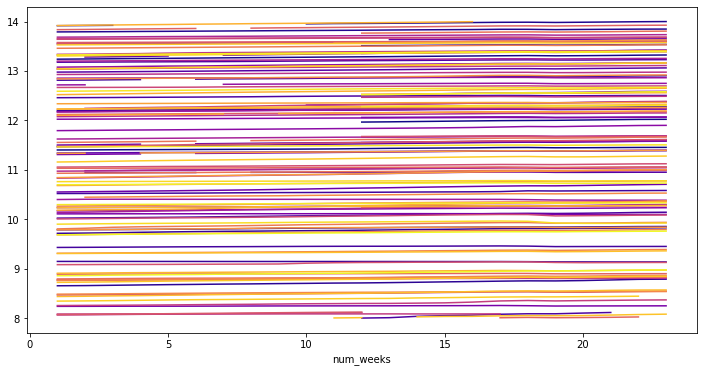

In [19]:
ts_data['log_fol_value'] = np.log(ts_data['fol_value'] +330)
ts_data['log_lis_value'] = np.log(ts_data['lis_value'] +333)

display_weekly_trend(ts_data, 'log_fol_value', upper_limit=14, lower_limit=8); 

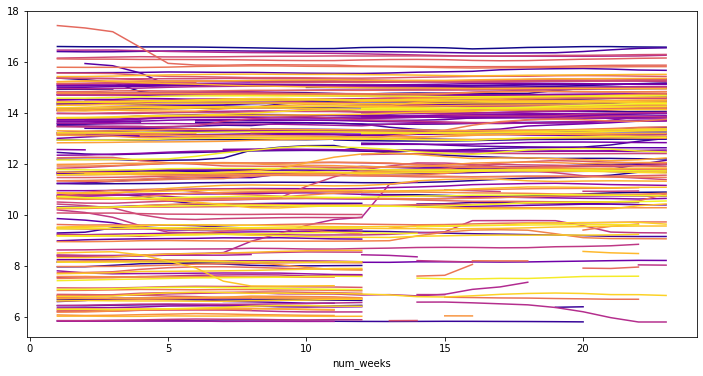

In [20]:
display_weekly_trend(ts_data, 'log_lis_value'); 

This looks almost exactly like the existing popularity score on spotify. Mistery solved.

I'm also curious to see if these weekly values are reflected in the original `*_weekly_diff` columns.

In [21]:
cols = ['fol_weekly_diff', 'pop_weekly_diff', 'lis_weekly_diff']
df1 = df.groupby('artist', as_index=False)[cols].mean()
df1.describe().round(2)

,fol_weekly_diff,pop_weekly_diff,lis_weekly_diff
count,238.00,238.00,230.00
mean,1358.63,0.11,-9826.35
std,3936.75,0.35,118258.46
min,-9.00,-2.00,-1117492.00
25%,1.00,0.00,-8135.50
50%,43.00,0.00,-41.00
75%,666.00,0.00,9.75
max,29900.00,1.00,1203116.00


In [22]:
df1 = pd.merge(ts_data, df1, on='artist', how='left')
df1.describe().round(2)

,num_weeks,fol_value,pop_value,lis_value,log_fol_value,log_lis_value,fol_weekly_diff,pop_weekly_diff,lis_weekly_diff
count,4339.00,4339.00,4339.00,4301.00,4339.00,4301.00,4202.00,4202.00,4112.00
mean,12.07,419238.32,43.98,1299266.61,10.36,11.70,1697.98,0.13,-11890.08
std,6.58,1051056.47,23.56,2535728.20,2.74,3.03,4407.61,0.35,133674.81
min,1.00,1.00,0.00,1.00,5.80,5.81,-9.00,-2.00,-1117492.00
25%,6.00,2306.00,26.00,11467.00,7.88,9.38,8.00,0.00,-12758.00
50%,12.00,32664.71,48.00,201782.14,10.40,12.22,143.00,0.00,-388.00
75%,18.00,326659.93,64.00,1595790.86,12.70,14.28,1163.00,0.00,54.00
max,23.00,7861215.00,94.75,37091085.00,15.88,17.43,29900.00,1.00,1203116.00


In [23]:
df1[df1['num_weeks'] > 21].head(5).round(2)

,artist,num_weeks,fol_value,pop_value,lis_value,log_fol_value,log_lis_value,fol_weekly_diff,pop_weekly_diff,lis_weekly_diff
21,20syl,22,93874.14,56.0,432909.43,11.45,12.98,229.0,0.0,2.0
22,20syl,23,94029.00,56.0,432673.00,11.45,12.98,229.0,0.0,2.0
44,21 Savage,22,7835785.14,86.0,16025124.71,15.87,16.59,21294.0,0.0,-1117492.0
45,21 Savage,23,7861215.00,86.0,15920472.00,15.88,16.58,21294.0,0.0,-1117492.0
56,3 Um Só,22,165825.14,43.0,53518.43,12.02,10.89,919.0,0.0,-877.0


Well, it's not an exact match, but the numbers are only off by a small percentage, maybe their date ranges for each week are different than ours. 

### Generating Ranking Using Weighted Averages

In order to generate a target value for regression methods, or to use it as the new artist score directly, next we will advise a heuristic algorithm to aggregate the relevant columns, namely:
- `fol_value`	
- `pop_value`	
- `lis_value`
- `fol_weekly_diff`	
- `pop_weekly_diff`	
- `lis_weekly_diff`
- `fol_weekly_diff_percent`
- `pop_weekly_diff_percent`
- `lis_weekly_diff_percent`

The first three represent the actual current values that reflect the rank of an artist in an absolute sense, the second group of three weekly differences shows the trend of whether the artist is gaining or losing listeners, followers and popularity, and the third group of three weekly difference percentages shows whether this gain or loss is significant relative to the actual current values. This last group is important if we want to level the playing field between well-established and new up-and-coming artist: the more weight we assign to values in the third group, the more we can potentially promote less known artists, given that they are gaining listeners, followers and popularity. (Ideally, the resulting scores should be checked by someone who actually knows these artists and is able to tell if they deserve higher scores.)

- On a second thought, it would probably be better to work with log transformed values only, since the distribution of values is much more even.
- Also, `minmaxscaler` should be applied to each column before applying the agreed upon weights, so that it is easier to see and explain which columns are deemed more important in claculating our ranking.